# Importing Library

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Input, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model, Sequential 

early_stopping = EarlyStopping(patience=10)

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(777)

print(tf.__version__)

Using TensorFlow backend.


1.5.1


##  Functions library

In [2]:
# prediction
def check_correct(predict, y):
    result = {}
    result['resistant-correct'] = 0
    result['resistant-wrong'] = 0
    result['sensitive-correct'] = 0
    result['sensitive-wrong'] = 0

    for i in range(len(predict)) :
        if predict[i] == y[i] :
            if y[i] == 0 :
                result['sensitive-correct'] += 1
            else :
                result['resistant-correct'] += 1
        else :
            if y[i] == 0 :
                result['sensitive-wrong'] += 1
            else :
                result['resistant-wrong'] += 1

    #for result_k, result_v in result.items():
    #    print(result_k +" : "+ str(result_v))
    sensitivity=result['resistant-correct']/(result['resistant-correct']+result['resistant-wrong'])
    specificity=result['sensitive-correct']/(result['sensitive-correct']+result['sensitive-wrong'])
    #print("Sensitivity :", sensitivity)
    #print("Specificity :", specificity)
    return sensitivity, specificity

In [3]:
# devide raw data into train / test & x_val / y_val
def data_split(raw_data, index_col, test_index):
    
    train_data = raw_data.iloc[list(raw_data.iloc[:,index_col]!=test_index)]
    test_data = raw_data.iloc[list(raw_data.iloc[:,index_col]==test_index)]
    
    y_val = train_data.Platinum_Status
    x_val = train_data.drop(["Platinum_Status","index"],axis=1)
    test_y_val = test_data.Platinum_Status
    test_x_val = test_data.drop(["Platinum_Status","index"],axis=1)
    
    return train_data, test_data, y_val, x_val, test_y_val, test_x_val

    # raw_data: have gene_expressions(maybe multiple columns), index column, Platinum_Status column.


In [4]:
# calculate all of model performance 
# - predictions(probability) / labeled predictions(0/1) / Loss / Accuracy / Sensitivity / Specificity / AUC values of Train / Test dataset.
# using trained models, or you can put predictions(probability) passively(in this case, Loss & Accuracy do not provided.)
def model_performance(information=False, Input_Prediction_Passively=False, using_model=None, tr_predictions=None, ts_predictions=None, tr_x_val=None, tr_y_val=None, ts_x_val=None, ts_y_val=None, output_list=None):
    
    if information == True:            
        print("options model_performance:\n1) using_model: keras models that you want to check performance. \"Input_Prediction_Passive\" option for input prediction list instead using models.\n3) tr_predictions & ts_predictions: prediction input passively. put this data only when not using keras model.\n4) tr_x_val & ts_x_val: input samples of train/test samples.\n4) tr_y_val & ts_y_val: results of train/test samples.\n5) output_list: return values that you want to recieve.\n CAUTION: Essential variable.\n\t tr_loss, tr_accuracy, tr_sensitivity, tr_specificity, tr_predictions, labeled_tr_predictions, tr_predictions_flat, roc_auc_tr,\nts_loss, ts_accuracy, ts_sensitivity, ts_specificity, ts_predictions, labeled_ts_predictions, ts_predictions_flat, roc_auc_ts,\nroc_auc_total\n\n* CAUTION: if 'None' value is returned, please check your input tr inputs(None value for tr outputs) or ts inputs(None value for ts outputs).") 
        return 0
    elif information != False:
        print("for using information options, please set 'information' variable for 'True'")
        return -1
    
    if using_model is None:
        if Input_Prediction_Passively == False:
            print("ERROR: There are no models for using.\nusing \"model_performance(information = True)\" for getting informations of this function.") 
            return -1
        elif (tr_predictions is None) and (ts_predictions is None): # No model/prediction input. no performance should be calculated.
                print("ERROR: Input prediction list instead using saved model.")
                return -1
        else: # No model input, but Input_Prediction_Passively is True & input prediction is valid.
            tr_loss,tr_accuracy= None, None
            ts_loss,ts_accuracy= None, None
            
    elif Input_Prediction_Passively == True: # both of model/prediction putted, could cause confusing.
        ch = input("You put both model and prediction. Select one method:\n'p' for using prediction only, 'm' using models only, 'n' for quit the function.")
        while 1:
            if ch == 'p':
                using_model = None
                break
            elif ch == 'm':
                tr_predictions = None
                ts_predictions = None
                break
            elif ch == 'e':
                return 0
            else:
                print("you put worng option: "+str(ch))
            ch = input("Select one method:\n'p' for using prediction only, 'm' using models only, 'n' for quit the function.")
                
    if output_list is None:
        print("ERROR: There are no output_list for return.\nusing \"model_performance(information = True)\" for getting informations of this function.")
        return -1
    
    if not(tr_x_val is None) and not(tr_y_val is None):
        # predict tr result only when no tr_prediction input
        if tr_predictions is None:
            tr_loss,tr_accuracy= using_model.evaluate(tr_x_val,tr_y_val)
            tr_predictions = using_model.predict(tr_x_val)
        # tr sensitivity / specificity
        labeled_tr_predictions = np.where(tr_predictions > 0.5, 1, 0).flatten()
        tr_sensitivity, tr_specificity = check_correct(labeled_tr_predictions, tr_y_val)
        tr_predictions_flat = tr_predictions[:,0]   
        # roc(tr)
        fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(tr_y_val, tr_predictions)
        roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)
    
    if not(ts_x_val is None) and not(ts_y_val is None):
        # predict ts result only when no ts_prediction input
        if ts_predictions is None:
            ts_loss,ts_accuracy= using_model.evaluate(ts_x_val,ts_y_val)
            ts_predictions = using_model.predict(ts_x_val)
        labeled_ts_predictions = np.where(ts_predictions > 0.5, 1, 0).flatten()
        ts_sensitivity, ts_specificity = check_correct(labeled_ts_predictions, ts_y_val)
        ts_predictions_flat = ts_predictions[:,0]   
        # roc(ts)
        fpr_ts, tpr_ts, threshold_ts = metrics.roc_curve(ts_y_val, ts_predictions)
        roc_auc_ts = metrics.auc(fpr_ts, tpr_ts)    
    
    if (not(tr_x_val is None) and not(tr_y_val is None)) and (not(ts_x_val is None) and not(ts_y_val is None)):
        y_true = np.append(tr_y_val, ts_y_val)
        y_pred = np.append(tr_predictions, ts_predictions)
        fpr_total, tpr_total, threshold_total = metrics.roc_curve(y_true, y_pred)
        roc_auc_total = metrics.auc(fpr_total, tpr_total)
        
        
    return_list = []
    
    for output in output_list:
        
        if(output == "tr_loss"):
            return_list.append(tr_loss)
                               
        elif(output == "tr_accuracy"):
            return_list.append(tr_accuracy)
                               
        elif(output == "tr_sensitivity"):
            return_list.append(tr_sensitivity)
                               
        elif(output == "tr_specificity"):
            return_list.append(tr_specificity)
                               
        elif(output == "tr_predictions"):
            return_list.append(tr_predictions)
                               
        elif(output == "labeled_tr_predictions"):
            return_list.append(labeled_tr_predictions)
                               
        elif(output == "tr_predictions_flat"):
            return_list.append(tr_predictions_flat)
            
        elif(output == "roc_auc_tr"):
            return_list.append(roc_auc_tr)

        elif(output == "ts_loss"):
            return_list.append(ts_loss)
                               
        elif(output == "ts_accuracy"):
            return_list.append(ts_accuracy)
                               
        elif(output == "ts_sensitivity"):
            return_list.append(ts_sensitivity)
                               
        elif(output == "ts_specificity"):
            return_list.append(ts_specificity)
                               
        elif(output == "ts_predictions"):
            return_list.append(ts_predictions)
                               
        elif(output == "labeled_ts_predictions"):
            return_list.append(labeled_ts_predictions)
                               
        elif(output == "ts_predictions_flat"):
            return_list.append(ts_predictions_flat)
        
        elif(output == "roc_auc_ts"):
            return_list.append(roc_auc_ts)
            
        elif(output == "roc_auc_total"):
            return_list.append(roc_auc_total)
                               
        else:
            print("There are no options <"+str(output)+">. Please refer these output options:\ntr_loss, tr_accuracy, tr_sensitivity, tr_specificity, tr_predictions, labeled_tr_predictions, tr_predictions_flat, roc_auc_tr,\nts_loss, ts_accuracy, ts_sensitivity, ts_specificity, ts_predictions, labeled_ts_predictions, ts_predictions_flat, roc_auc_ts,\nroc_auc_total")
    
    return return_list

# 1. Preparation: import & preprocessing data + import module

## Input path & name of models / raw data for ensemble

In [38]:
# change model_path & each model_name.
# Caution: If you want to change input models, you also have to change selected data types.

# ex) if you want to put these models: two CV, one Annot_3000,  one Var, one new_Diff, one Clin.

'''

m_1_name = CV_400_1.h5
m_2_name = CV_400_2.h5
m_3_name = Annot_3000_400_1.h5
m_4_name = Var_400_0.h5
m_5_name = new_Diff_400_2.h5
m_6_name = Clin_400_1.h5
--> if you change this part,

select_types = [types[1], # "inter_by_names_CV_400"
                types[1], # "inter_by_names_CV_400"
                types[0], # "inter_by_names_Annotation3000_400"
                types[2], # "inter_by_names_Var_400"
                types[3], # "inter_by_names_new_Diff_400"
                types[4]] # "inter_by_names_Clin"
--> you also have to change this part.

'''

types = ["inter_by_names_Annotation3000_400", "inter_by_names_CV_400", 
         "inter_by_names_Var_400", "inter_by_names_new_Diff_400",
         "inter_by_names_Clin", 
         "inter_by_names_SNV" 
         ]

# input model path & ensemble data(Transcriptome, Cinical Information, Somatic Mutation data)
# data path(server): /home/tjahn/TCGA_Ovary/01.Data/DNN/TC_intersect_subsamples_by_names 
model_path = "C:/test/best_models/"
path = "C:/test/TC_intersect_subsamples_by_names/"
save_model_path = "../models/Ovary"
save_prediction_path = "../result/"

# change 'types' and 'load_model' part for using another models.
m_1_name = "new_Diff_400_2.h5"
m_2_name = "CV_400_0.h5"
m_3_name = "Var_400_0.h5"
m_4_name = "new_Diff_400_0.h5"
m_5_name = "Clin_2.h5"
m_6_name = "SNV_1.h5"
select_types = [types[3],
                types[1],
                types[2],
                types[3],
                types[4],
                types[5]]

In [71]:
select = [1, 3, 4]
print(select)

[1, 3, 4]


## Import Data

In [72]:
file_1 = path+select_types[0]+".csv"
file_2 = path+select_types[1]+".csv"
file_3 = path+select_types[2]+".csv"
file_4 = path+select_types[3]+".csv"
file_5 = path+select_types[4]+".csv"
file_6 = path+select_types[5]+".csv"

idx_col = 0

data_1 = pd.read_csv(file_1,index_col=idx_col)
data_2 = pd.read_csv(file_2,index_col=idx_col)
data_3 = pd.read_csv(file_3,index_col=idx_col)
data_4 = pd.read_csv(file_4,index_col=idx_col)
data_5 = pd.read_csv(file_5,index_col=idx_col)
data_6 = pd.read_csv(file_6,index_col=idx_col)

sample_1,features_1 = data_1.shape
sample_2,features_2 = data_2.shape
sample_3,features_3 = data_3.shape
sample_4,features_4 = data_4.shape
sample_5,features_5 = data_5.shape
sample_6,features_6 = data_6.shape

# Data frame include index & Platinum_Status column, substract 2 to calculate real number of features 
[features_1, features_2, features_3, features_4, features_5, features_6] = [features_1-2, features_2-2, features_3-2, features_4-2, features_5-2, features_6-2]

print("[1] file_name: ", select_types[0], "\nsample : {}  \nfeatures : {}".format(sample_1,features_1))
print("[2] file_name: ", select_types[1], "\nsample : {}  \nfeatures : {}".format(sample_2,features_2))
print("[3] file_name: ", select_types[2], "\nsample : {}  \nfeatures : {}".format(sample_3,features_3))
print("[4] file_name: ", select_types[3], "\nsample : {}  \nfeatures : {}".format(sample_4,features_4))
print("[5] file_name: ", select_types[4], "\nsample : {}  \nfeatures : {}".format(sample_5,features_5))
print("[6] file_name: ", select_types[5], "\nsample : {}  \nfeatures : {}".format(sample_6,features_6))

# Split Train Test Data

train_data_1, test_data_1, y_val_1, x_val_1, test_y_val_1, test_x_val_1 = data_split(raw_data = data_1, index_col = -1, test_index = 1)
train_data_2, test_data_2, y_val_2, x_val_2, test_y_val_2, test_x_val_2 = data_split(raw_data = data_2, index_col = -1, test_index = 1)
train_data_3, test_data_3, y_val_3, x_val_3, test_y_val_3, test_x_val_3 = data_split(raw_data = data_3, index_col = -1, test_index = 1)
train_data_4, test_data_4, y_val_4, x_val_4, test_y_val_4, test_x_val_4 = data_split(raw_data = data_4, index_col = -1, test_index = 1)
train_data_5, test_data_5, y_val_5, x_val_5, test_y_val_5, test_x_val_5 = data_split(raw_data = data_5, index_col = -1, test_index = 1)
train_data_6, test_data_6, y_val_6, x_val_6, test_y_val_6, test_x_val_6 = data_split(raw_data = data_6, index_col = -1, test_index = 1)

[1] file_name:  inter_by_names_new_Diff_400 
sample : 153  
features : 400
[2] file_name:  inter_by_names_CV_400 
sample : 153  
features : 400
[3] file_name:  inter_by_names_Var_400 
sample : 153  
features : 400
[4] file_name:  inter_by_names_new_Diff_400 
sample : 153  
features : 400
[5] file_name:  inter_by_names_Clin 
sample : 153  
features : 35
[6] file_name:  inter_by_names_SNV 
sample : 153  
features : 6970


In [75]:
def ensemble_coverage(inputModels,x,y):
    outputModels = []
    modelInfo = []
    coverageTotal= [False]*len(y)
    
    for m in inputModels:
        yHat = m.predict(x)
        yHat = [round(i) for [i] in yHat]
        
        loss, acc = m.evaluate(x,y)
        modelInfo.append((m,yHat,acc))
    
    modelInfo.sort(key=lambda x : x[2],reverse=True)
    
    for m,yHat,acc in modelInfo:
        beforeCoverage = sum(coverageTotal)
        coverage = [a == b for a,b in zip(y,yHat)]
        coverageTotal = [a or b for a,b in zip(coverageTotal,coverage)]
        afterCoverage = sum(coverageTotal)
        
        print(afterCoverage/len(y))
        
        if afterCoverage > beforeCoverage:
            outputModels.append(m)
            print("Increased Coverage : model added!")
        else:
            print("Same Coverage : model not added")
        if afterCoverage == len(y):
            print("Fully Covered!")
            break
        
                
    return outputModels

inputModels = [model_1_l,model_3_l,model_4_l]
x = test_x_val_1
y = test_y_val_1

ensemble_models = ensemble_coverage(inputModels,x,y)
print("number of final models for ensemble: ",len(ensemble_models))

31/31 [==============================] - 0s 129us/step
0.8387096774193549
Increased Coverage : model added!
0.8709677419354839
Increased Coverage : model added!
0.967741935483871
Increased Coverage : model added!
number of final models for ensemble:  3


## Import separate models & evaluation

In [76]:
# model load & evaluation. <model_n_l> is full-layer model, <model_n_l_new> is without-sigmoid-layer model.
'''
Each model's tr_accuracy can be differ to original model, but ts_accuracy should be same to original tested models.
Because we using full-size data(about 200 patients data used Transcriptome, Clinical, SNV models.) for train each models.
In contrast, in this code, we using ensemble-input data(intersected 153 patients).
For-training-patients may be different in ensemble data and whole size data, but for-test-patients are the same.
'''

model_1_l = load_model(model_path+m_1_name)
output_list_1 = model_performance(Input_Prediction_Passively=False, using_model=model_1_l, tr_x_val=x_val_1, tr_y_val=y_val_1, ts_x_val = test_x_val_1, ts_y_val= test_y_val_1, output_list= ["tr_accuracy", "ts_accuracy", ""])

m_1_l_tr_loss,m_1_l_tr_accuracy=model_1_l.evaluate(x_val_1,y_val_1)
m_1_l_loss,m_1_l_accuracy= model_1_l.evaluate(test_x_val_1,test_y_val_1)
model_1_l_new = Model(inputs = model_1_l.input, outputs=model_1_l.get_layer(model_1_l.layers[-2].name).output)

print(select_types[0])
print("Train Accuracy: {}".format(m_1_l_tr_accuracy))
print("Test Accuracy: {}".format(m_1_l_accuracy))

model_2_l = load_model(model_path+m_2_name)
m_2_l_tr_loss,m_2_l_tr_accuracy=model_2_l.evaluate(x_val_2,y_val_2)
m_2_l_loss,m_2_l_accuracy= model_2_l.evaluate(test_x_val_2,test_y_val_2)
model_2_l_new = Model(inputs = model_2_l.input, outputs=model_2_l.get_layer(model_2_l.layers[-2].name).output)

print(select_types[1])
print("Train Accuracy: {}".format(m_2_l_tr_accuracy))
print("Test Accuracy: {}".format(m_2_l_accuracy))

model_3_l = load_model(model_path+m_3_name)
m_3_l_tr_loss,m_3_l_tr_accuracy=model_3_l.evaluate(x_val_3,y_val_3)
m_3_l_loss,m_3_l_accuracy= model_3_l.evaluate(test_x_val_3,test_y_val_3)
model_3_l_new = Model(inputs = model_3_l.input, outputs=model_3_l.get_layer(model_3_l.layers[-2].name).output)

print(select_types[2])
print("Train Accuracy: {}".format(m_3_l_tr_accuracy))
print("Test Accuracy: {}".format(m_3_l_accuracy))

model_4_l = load_model(model_path+m_4_name)
m_4_l_tr_loss,m_4_l_tr_accuracy=model_4_l.evaluate(x_val_4,y_val_4)
m_4_l_loss,m_4_l_accuracy= model_4_l.evaluate(test_x_val_4,test_y_val_4)
model_4_l_new = Model(inputs = model_4_l.input, outputs=model_4_l.get_layer(model_4_l.layers[-2].name).output)

print(select_types[3])
print("Train Accuracy: {}".format(m_4_l_tr_accuracy))
print("Test Accuracy: {}".format(m_4_l_accuracy))

model_5_l = load_model(model_path+m_5_name)
m_5_l_tr_loss,m_5_l_tr_accuracy=model_5_l.evaluate(x_val_5,y_val_5)
m_5_l_loss,m_5_l_accuracy= model_5_l.evaluate(test_x_val_5,test_y_val_5)
model_5_l_new = Model(inputs = model_5_l.input, outputs=model_5_l.get_layer(model_5_l.layers[-2].name).output)

print(select_types[4])
print("Train Accuracy: {}".format(m_5_l_tr_accuracy))
print("Test Accuracy: {}".format(m_5_l_accuracy))

model_6_l = load_model(model_path+m_6_name)
m_6_l_tr_loss,m_6_l_tr_accuracy=model_6_l.evaluate(x_val_6,y_val_6)
m_6_l_loss,m_6_l_accuracy= model_6_l.evaluate(test_x_val_6,test_y_val_6)
model_6_l_new = Model(inputs = model_6_l.input, outputs=model_6_l.get_layer(model_6_l.layers[-2].name).output)

print(select_types[5])
print("Train Accuracy: {}".format(m_6_l_tr_accuracy))
print("Test Accuracy: {}".format(m_6_l_accuracy))

m_1_predictions = model_1_l.predict(x_val_1)
m_2_predictions = model_2_l.predict(x_val_2)
m_3_predictions = model_3_l.predict(x_val_3)
m_4_predictions = model_4_l.predict(x_val_4)
m_5_predictions = model_5_l.predict(x_val_5)
m_6_predictions = model_6_l.predict(x_val_6)

m_1_test_predictions = model_1_l.predict(test_x_val_1)
m_2_test_predictions = model_2_l.predict(test_x_val_2)
m_3_test_predictions = model_3_l.predict(test_x_val_3)
m_4_test_predictions = model_4_l.predict(test_x_val_4)
m_5_test_predictions = model_5_l.predict(test_x_val_5)
m_6_test_predictions = model_6_l.predict(test_x_val_6)

31/31 [==============================] - 0s 96us/step
inter_by_names_new_Diff_400
Train Accuracy: 0.9918032786885246
Test Accuracy: 0.8387096524238586
31/31 [==============================] - 0s 161us/step
inter_by_names_CV_400
Train Accuracy: 1.0
Test Accuracy: 0.6451612710952759
31/31 [==============================] - 0s 161us/step
inter_by_names_Var_400
Train Accuracy: 0.9426229449569202
Test Accuracy: 0.7096773982048035
31/31 [==============================] - 0s 129us/step
inter_by_names_new_Diff_400
Train Accuracy: 0.9508196662683956
Test Accuracy: 0.8387096524238586
31/31 [==============================] - 0s 257us/step
inter_by_names_Clin
Train Accuracy: 0.7704918062100645
Test Accuracy: 0.7419354915618896
31/31 [==============================] - 0s 225us/step
inter_by_names_SNV
Train Accuracy: 1.0
Test Accuracy: 0.774193525314331


### Evaluating seperate model's performance

In [77]:
print("< "+select_types[0]+" > tr: "+str(m_1_l_tr_accuracy)+", ts: "+str(m_1_l_accuracy))
print("< "+select_types[1]+" > tr: "+str(m_2_l_tr_accuracy)+", ts: "+str(m_2_l_accuracy))
print("< "+select_types[2]+" > tr: "+str(m_3_l_tr_accuracy)+", ts: "+str(m_3_l_accuracy))
print("< "+select_types[3]+" > tr: "+str(m_4_l_tr_accuracy)+", ts: "+str(m_4_l_accuracy))
print("< "+select_types[4]+" > tr: "+str(m_5_l_tr_accuracy)+", ts: "+str(m_5_l_accuracy))
print("< "+select_types[5]+" > tr: "+str(m_6_l_tr_accuracy)+", ts: "+str(m_6_l_accuracy))

< inter_by_names_new_Diff_400 > tr: 0.9918032786885246, ts: 0.8387096524238586
< inter_by_names_CV_400 > tr: 1.0, ts: 0.6451612710952759
< inter_by_names_Var_400 > tr: 0.9426229449569202, ts: 0.7096773982048035
< inter_by_names_new_Diff_400 > tr: 0.9508196662683956, ts: 0.8387096524238586
< inter_by_names_Clin > tr: 0.7704918062100645, ts: 0.7419354915618896
< inter_by_names_SNV > tr: 1.0, ts: 0.774193525314331


# 2. Modeling Ensemble model

## 1) DNN-Combiner Ensmeble

### Building original ensemble model

In [81]:
print("################################## DNN em ##################################")
print("select: "+str(select))
for select_type_i in select:
    print(select_types[select_type_i-1])
print("#############################################################################################")

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_em = 0.3
drop_out_em = 0.5
layers = [5]
em_tr_loss_best = 100 # for saving best loss value 
best_em_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
m_tr_predictions = [m_1_predictions, m_2_predictions, m_3_predictions, m_4_predictions, m_5_predictions, m_6_predictions]
m_tr_predictions_select = []

for i in range(len(select)):
    m_tr_predictions_select.append(m_tr_predictions[select[i]-1])
    #print(m_tr_predictions[select[i]-1].shape)
    
em_x_val = np.concatenate(m_tr_predictions_select, axis=1)

input_em = Input(shape=(len(select),))
em_m_dp = Dropout(input_drop_out_em)(input_em)
for i in layers:
    em_m = Dense(i,activation='relu')(em_m_dp)
    em_m_dp = Dropout(drop_out_em)(em_m)
em_m_final = em_m_dp
output_em = Dense(1, activation="sigmoid")(em_m_final)
em_model = Model(inputs=input_em,outputs=output_em)
em_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    em_model.fit(em_x_val, y_val_1, nb_epoch=1)
    em_tr_loss=em_model.evaluate(em_x_val,y_val_1)[0]
    if em_tr_loss < em_tr_loss_best: # new best model. count reset.
        em_tr_loss_best = em_tr_loss
        count=0
        best_em_model = em_model
    if count>3: # no increase three time. stop.
        em_model = best_em_model
        break
    else: count=count+1
print("##################### DNN ensemble model trained. #####################")
# 4) save model

em_model.save(save_model_path+"/m_em.h5")
print("##################### DNN ensemble model saved. #####################")

################################## DNN em ##################################
select: [1, 3, 4]
inter_by_names_new_Diff_400
inter_by_names_Var_400
inter_by_names_new_Diff_400
#############################################################################################


c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
122/122 [==============================] - 1s 5ms/step
Epoch 1/1
122/122 [==============================] - 0s 139us/step
Epoch 1/1
122/122 [==============================] - 0s 147us/step
Epoch 1/1
122/122 [==============================] - 0s 98us/step
Epoch 1/1
122/122 [==============================] - 0s 123us/step
Epoch 1/1
122/122 [==============================] - 0s 106us/step
Epoch 1/1
122/122 [==============================] - 0s 180us/step
Epoch 1/1
122/122 [==============================] - 0s 90us/step
Epoch 1/1
122/122 [==============================] - 0s 98us/step
Epoch 1/1
122/122 [==============================] - 0s 106us/step
Epoch 1/1
122/122 [==============================] - 0s 131us/step
Epoch 1/1
122/122 [==============================] - 0s 139us/step
Epoch 1/1
122/122 [==============================] - 0s 114us/step
Epoch 1/1
122/122 [==============================] - 0s 98us/step
Epoch 1/1
122/122 [==============================] - 0s 131us/step
E

### Evaluating _DNN Combiner_ ensemble model

In [82]:
m_test_predictions = [m_1_test_predictions, m_2_test_predictions, m_3_test_predictions, m_4_test_predictions, m_5_test_predictions, m_6_test_predictions]
m_test_predictions_select = []   
#def prediction_result(pathway, tr_x_val, tr_y_val, ts_x_val, ts_y_val, tr_patients, ts_patients)
for i in range(len(select)):
    m_test_predictions_select.append(m_test_predictions[select[i]-1])
    
em_test_x_val = np.concatenate(m_test_predictions_select, axis=1)

em_output_list = model_performance(
    information = False, using_model=em_model,Input_Prediction_Passively = False, 
    tr_x_val=em_x_val, tr_y_val=y_val_1, ts_x_val=em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

em_tr_loss, em_tr_accuracy, em_tr_sensitivity, em_tr_specificity, em_tr_predictions, em_labeled_tr_predictions, em_tr_predictions_flat, em_roc_auc_tr, em_ts_loss, em_ts_accuracy, em_ts_sensitivity, em_ts_specificity, em_ts_predictions,em_labeled_ts_predictions, em_ts_predictions_flat, em_roc_auc_ts, em_roc_auc_total = em_output_list

print("Overall AUC: ", em_roc_auc_total)
print("Train AUC: ", em_roc_auc_tr)
print("Test AUC: ", em_roc_auc_ts)

print("Train Accuracy: {}".format(em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(em_tr_sensitivity)+", "+str(em_tr_specificity))
print("Test Accuracy: {}".format(em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(em_ts_sensitivity)+", "+str(em_ts_specificity))

31/31 [==============================] - 0s 64us/step
Overall AUC:  0.9737843551797041
Train AUC:  0.9996657754010695
Test AUC:  0.8080808080808081
Train Accuracy: 0.9754098302028218
Train Sensitivities & Specificities : 0.9117647058823529, 1.0
Test Accuracy: 0.7419354915618896
Test Sensitivities & Specificities : 0.4444444444444444, 0.8636363636363636


In [12]:
# save prediction result.

tr_df_em = pd.DataFrame(data={"patient":list(train_data_1.index), "hypothesis 1": list(em_tr_predictions_flat), 
                        "prediction":list(em_labeled_tr_predictions), "Platinum_Status":list(y_val_1)})
tr_df_em.to_csv(save_prediction_path+"prediction_result_DNN_em_tr.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])

ts_df_em = pd.DataFrame(data={"patient":list(test_data_1.index), "hypothesis 1": list(em_ts_predictions_flat), 
                        "prediction":list(em_labeled_ts_predictions), "Platinum_Status":list(test_y_val_1)})
ts_df_em.to_csv(save_prediction_path+"prediction_result_DNN_em_ts.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])


## 2) Mean Ensemble

### Evaluating _mean_ ensemble model

In [83]:
mean_em_tr_predictions=sum(m_tr_predictions_select)/len(select)
mean_em_ts_predictions=sum(m_test_predictions_select)/len(select)

mean_em_output_list = model_performance(
    information = False, using_model=None,Input_Prediction_Passively = True, 
    tr_predictions=mean_em_tr_predictions, ts_predictions=mean_em_ts_predictions, 
    tr_x_val=em_x_val, tr_y_val=y_val_1, ts_x_val=em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_sensitivity", "tr_specificity",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_sensitivity", "ts_specificity",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])
mean_em_tr_sensitivity, mean_em_tr_specificity,  mean_em_labeled_tr_predictions, mean_em_tr_predictions_flat, mean_em_roc_auc_tr, mean_em_ts_sensitivity, mean_em_ts_specificity, mean_em_labeled_ts_predictions, mean_em_ts_predictions_flat, mean_em_roc_auc_ts, mean_em_roc_auc_total = mean_em_output_list

mean_em_tr_accuracy = sum(mean_em_labeled_tr_predictions==y_val_1.values)/len(y_val_1)
mean_em_ts_accuracy = sum(mean_em_labeled_ts_predictions==test_y_val_1.values)/len(test_y_val_1)

print("Overall AUC: ", mean_em_roc_auc_total)
print("Train AUC: ", mean_em_roc_auc_tr)
print("Test AUC: ", mean_em_roc_auc_ts)

print("Train Accuracy: {}".format(mean_em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(mean_em_tr_sensitivity)+", "+str(mean_em_tr_specificity))
print("Test Accuracy: {}".format(mean_em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(mean_em_ts_sensitivity)+", "+str(mean_em_ts_specificity))

Overall AUC:  0.9706131078224102
Train AUC:  0.9996657754010695
Test AUC:  0.7979797979797979
Train Accuracy: 0.9836065573770492
Train Sensitivities & Specificities : 0.9411764705882353, 1.0
Test Accuracy: 0.8064516129032258
Test Sensitivities & Specificities : 0.6666666666666666, 0.8636363636363636


In [84]:
# save prediction result.

tr_df_mean_em = pd.DataFrame(data={"patient":list(train_data_1.index), "hypothesis 1": list(mean_em_tr_predictions_flat), 
                        "prediction":list(mean_em_labeled_tr_predictions), "Platinum_Status":list(y_val_1)})
tr_df_mean_em.to_csv(save_prediction_path+"prediction_result_mean_em_tr.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])

ts_df_mean_em = pd.DataFrame(data={"patient":list(test_data_1.index), "hypothesis 1": list(mean_em_ts_predictions_flat), 
                        "prediction":list(mean_em_labeled_ts_predictions), "Platinum_Status":list(test_y_val_1)})
ts_df_mean_em.to_csv(save_prediction_path+"prediction_result_mean_em_ts.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])

In [180]:
print(select)

[1, 3, 4]


In [179]:
model_test = load_model("G:/내 드라이브/Class/6과 7 사이(hell)/Lab/TCGA 난소암/Best_Models/18.09.15/best_models/Full_5+5.h5")
full_em_output_list = model_performance(
    information = False, using_model=model_test,Input_Prediction_Passively = False, 
    tr_x_val=full_em_x_val, tr_y_val=y_val_1, ts_x_val=full_em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

full_em_tr_loss, full_em_tr_accuracy, full_em_tr_sensitivity, full_em_tr_specificity, full_em_tr_predictions, full_em_labeled_tr_predictions, full_em_tr_predictions_flat, full_em_roc_auc_tr, full_em_ts_loss, full_em_ts_accuracy, full_em_ts_sensitivity, full_em_ts_specificity, full_em_ts_predictions,full_em_labeled_ts_predictions, full_em_ts_predictions_flat, full_em_roc_auc_ts, full_em_roc_auc_total = full_em_output_list

print("Overall AUC: ", full_em_roc_auc_total)
print("Train AUC: ", full_em_roc_auc_tr)
print("Test AUC: ", full_em_roc_auc_ts)

print("Train Accuracy: {}".format(full_em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(full_em_tr_sensitivity)+", "+str(full_em_tr_specificity))
print("Test Accuracy: {}".format(full_em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(full_em_ts_sensitivity)+", "+str(full_em_ts_specificity))

31/31 [==============================] - 0s 421us/step
Overall AUC:  0.9809725158562368
Train AUC:  1.0
Test AUC:  0.8686868686868686
Train Accuracy: 1.0
Train Sensitivities & Specificities : 1.0, 1.0
Test Accuracy: 0.9032257795333862
Test Sensitivities & Specificities : 0.8888888888888888, 0.9090909090909091


## 3) Transferred Ensemble Modeling 

### Making new input data for t-ensemble

In [106]:
results_m_1 = model_1_l_new.predict([x_val_1])
results_m_2 = model_2_l_new.predict([x_val_2])
results_m_3 = model_3_l_new.predict([x_val_3])
results_m_4 = model_4_l_new.predict([x_val_4])
results_m_5 = model_5_l_new.predict([x_val_5])
results_m_6 = model_6_l_new.predict([x_val_6])

results_m_sum = [results_m_1, results_m_2, results_m_3, results_m_4, results_m_5, results_m_6]
results_m_select = []

for i in range(len(select)):
    print(results_m_sum[select[i]-1].shape)
    results_m_select.append(results_m_sum[select[i]-1])

test_results_m_1 = model_1_l_new.predict([test_x_val_1])
test_results_m_2 = model_2_l_new.predict([test_x_val_2])
test_results_m_3 = model_3_l_new.predict([test_x_val_3])
test_results_m_4 = model_4_l_new.predict([test_x_val_4])
test_results_m_5 = model_5_l_new.predict([test_x_val_5])
test_results_m_6 = model_6_l_new.predict([test_x_val_6])

test_results_m_sum = [test_results_m_1, test_results_m_2, test_results_m_3, test_results_m_4, test_results_m_5, test_results_m_6]
test_results_m_select = []

for i in range(len(select)):
    test_results_m_select.append(test_results_m_sum[select[i]-1])
    print(test_results_m_sum[select[i]-1].shape)

t_em_test_x_val = np.concatenate(test_results_m_select, axis=1)
t_em_x_val = np.concatenate(results_m_select, axis=1)
print(t_em_x_val.shape)

(122, 5)
(122, 200)
(122, 200)
(31, 5)
(31, 200)
(31, 200)
(122, 405)


## full_ensemble

In [119]:
model_1_l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 2005      
_________________________________________________________________
batch_normalization_9 (Batch (None, 5)                 20        
_________________________________________________________________
activation_9 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 6         
Total params: 2,031
Trainable params: 2,021
Non-trainable params: 10
_________________________________________________________________


In [120]:
full_em_x_val = np.concatenate([x_val_1, em_x_val], axis = 1)
full_em_test_x_val = np.concatenate([test_x_val_1, em_test_x_val], axis = 1)

In [126]:
print(x_val_1.shape)
print(t_em_x_val.shape)
print(em_x_val.shape)
print(em_test_x_val.shape)
print(full_em_x_val.shape[1])
print(full_em_test_x_val.shape)

(122, 400)
(122, 405)
(122, 3)
(31, 3)
403
(31, 403)


In [176]:
print("mixed_model")

# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_full_em = 0.5
drop_out_full_em = 0
layers = [100]
full_em_tr_loss_best = 100 # for saving best loss value 
best_full_em_model=[] #for saving best model
count=0 # for early stopping

# 2) model build
input_full_em = Input(shape=(full_em_x_val.shape[1],))
full_em_m_bn = Dropout(input_drop_out_full_em)(input_full_em)
for i in layers:
    full_em_m = Dense(i)(full_em_m_bn)
    full_em_m_bn = BatchNormalization(axis=1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones')(full_em_m)
    full_em_m_ac = Activation("relu")(full_em_m_bn)

output_full_em = Dense(1, activation="sigmoid")(full_em_m_ac)
full_em_model = Model(inputs=input_full_em,outputs=output_full_em)
full_em_model.compile(optimizer=optimizers.Adam(), 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.
while 1:
    full_em_model.fit(full_em_x_val, y_val_1, batch_size=5,epochs=1)
    full_em_tr_loss, full_em_tr_accuracy =full_em_model.evaluate(full_em_x_val, y_val_1)
    if full_em_tr_loss < full_em_tr_loss_best: # new best model. count reset.
        full_em_tr_loss_best = full_em_tr_loss
        count=0
        best_full_em_model = full_em_model
        best_full_em_tr_accuracy = full_em_tr_accuracy
        print("best model: "+str(full_em_tr_accuracy))
    if count>20 or (best_full_em_tr_accuracy == 1): # no increase three time. stop.
        full_em_model = best_full_em_model
        break
    else: count=count+1
print("mixed_model trained.")

# 4) save model
full_em_model.save(save_model_path+"/full_em.h5")
print("mixed_model saved.")

# 5) evaluate model
full_em_output_list = model_performance(
    information = False, using_model=full_em_model,Input_Prediction_Passively = False, 
    tr_x_val=full_em_x_val, tr_y_val=y_val_1, ts_x_val=full_em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

full_em_tr_loss, full_em_tr_accuracy, full_em_tr_sensitivity, full_em_tr_specificity, full_em_tr_predictions, full_em_labeled_tr_predictions, full_em_tr_predictions_flat, full_em_roc_auc_tr, full_em_ts_loss, full_em_ts_accuracy, full_em_ts_sensitivity, full_em_ts_specificity, full_em_ts_predictions,full_em_labeled_ts_predictions, full_em_ts_predictions_flat, full_em_roc_auc_ts, full_em_roc_auc_total = full_em_output_list

print("Overall AUC: ", full_em_roc_auc_total)
print("Train AUC: ", full_em_roc_auc_tr)
print("Test AUC: ", full_em_roc_auc_ts)

print("Train Accuracy: {}".format(full_em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(full_em_tr_sensitivity)+", "+str(full_em_tr_specificity))
print("Test Accuracy: {}".format(full_em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(full_em_ts_sensitivity)+", "+str(full_em_ts_specificity))

mixed_model
Epoch 1/1
122/122 [==============================] - 3s 21ms/step
best model: 0.8032786836389636
Epoch 1/1
122/122 [==============================] - 0s 319us/step
best model: 0.8442622901963406
Epoch 1/1
122/122 [==============================] - 0s 319us/step
best model: 0.8852458967537177
Epoch 1/1
122/122 [==============================] - 0s 343us/step
best model: 0.9180327878623712
Epoch 1/1
122/122 [==============================] - 0s 335us/step
best model: 0.9508196662683956
Epoch 1/1
122/122 [==============================] - 0s 311us/step
best model: 0.9672131147540983
Epoch 1/1
122/122 [==============================] - 0s 294us/step
best model: 0.9672131147540983
Epoch 1/1
122/122 [==============================] - 0s 311us/step
best model: 0.959016387579871
Epoch 1/1
122/122 [==============================] - 0s 294us/step
best model: 0.9672131147540983
Epoch 1/1
122/122 [==============================] - 0s 327us/step
best model: 0.9754098360655737
Epoch 1/1


In [163]:
full_em_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 403)               0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 403)               0         
_________________________________________________________________
dense_128 (Dense)            (None, 100)               40400     
_________________________________________________________________
batch_normalization_42 (Batc (None, 100)               400       
_________________________________________________________________
activation_37 (Activation)   (None, 100)               0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 100)               400       
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 101       
Total para

In [121]:
# 1) parameter setting
adam = optimizers.Adam(lr=0.01)
input_drop_out_t_em = 0.5
drop_out_t_em = 0.5
layers = [100, 100, 100, 100]
full_em_tr_loss_best = 100 # for saving best loss value 
best_full_em_model=[] #for saving best model
count=0 # for early stopping


# 2) model build
input_t_em = Input(shape=(full_em_x_val.shape[1],))
full_em_m_dp = Dropout(input_drop_out_t_em)(input_t_em)
for i in layers:
    full_em_m = Dense(i,activation='relu')(full_em_m_dp)
    full_em_m_dp = Dropout(drop_out_em)(full_em_m)
full_em_m_final = full_em_m_dp
output_t_em = Dense(1, activation="sigmoid")(full_em_m_final)
full_em_model = Model(inputs=input_t_em,outputs=output_t_em)
full_em_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.

#full_em_model.fit(full_em_x_val, y_val_1, batch_size=5, epochs = 100, validation_split = 0.1, callbacks=[early_stopping])
while 1:
    full_em_model.fit(full_em_x_val, y_val_1, batch_size= 100, nb_epoch=1)
    full_em_tr_loss=full_em_model.evaluate(full_em_x_val,y_val_1)[0]
    if full_em_tr_loss < full_em_tr_loss_best: # new best model. count reset.
        full_em_tr_loss_best = full_em_tr_loss
        count=0
        best_full_em_model = full_em_model
    if count>20: # no increase three time. stop.
        full_em_model = best_full_em_model
        break
    else: count=count+1

print("full ensemble model trained.")
full_em_model.save(save_model_path+"f_em.h5")

c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
122/122 [==============================] - 1s 7ms/step
Epoch 1/1
122/122 [==============================] - 0s 245us/step
Epoch 1/1
122/122 [==============================] - 0s 245us/step
Epoch 1/1
122/122 [==============================] - 0s 180us/step
Epoch 1/1
122/122 [==============================] - 0s 188us/step
Epoch 1/1
122/122 [==============================] - 0s 204us/step
Epoch 1/1
122/122 [==============================] - 0s 180us/step
Epoch 1/1
122/122 [==============================] - 0s 221us/step
Epoch 1/1
122/122 [==============================] - 0s 237us/step
Epoch 1/1
122/122 [==============================] - 0s 163us/step
Epoch 1/1
122/122 [==============================] - 0s 155us/step
Epoch 1/1
122/122 [==============================] - 0s 155us/step
Epoch 1/1
122/122 [==============================] - 0s 261us/step
Epoch 1/1
122/122 [==============================] - 0s 196us/step
Epoch 1/1
122/122 [==============================] - 0s 155us/st

122/122 [==============================] - 0s 180us/step
Epoch 1/1
122/122 [==============================] - 0s 163us/step
Epoch 1/1
122/122 [==============================] - 0s 212us/step
Epoch 1/1
122/122 [==============================] - 0s 213us/step
Epoch 1/1
122/122 [==============================] - 0s 221us/step
Epoch 1/1
122/122 [==============================] - 0s 229us/step
Epoch 1/1
122/122 [==============================] - 0s 237us/step
Epoch 1/1
122/122 [==============================] - 0s 237us/step
Epoch 1/1
122/122 [==============================] - 0s 221us/step
Epoch 1/1
122/122 [==============================] - 0s 237us/step
Epoch 1/1
122/122 [==============================] - 0s 229us/step
Epoch 1/1
122/122 [==============================] - 0s 180us/step
Epoch 1/1
122/122 [==============================] - 0s 147us/step
Epoch 1/1
122/122 [==============================] - 0s 237us/step
Epoch 1/1
122/122 [==============================] - 0s 221us/step
Epoch

In [ ]:
full_em_output_list = model_performance(
    information = False, using_model=full_em_model,Input_Prediction_Passively = False, 
    tr_x_val=full_em_x_val, tr_y_val=y_val_1, ts_x_val=full_em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

full_em_tr_loss, full_em_tr_accuracy, full_em_tr_sensitivity, full_em_tr_specificity, full_em_tr_predictions, full_em_labeled_tr_predictions, full_em_tr_predictions_flat, full_em_roc_auc_tr, full_em_ts_loss, full_em_ts_accuracy, full_em_ts_sensitivity, full_em_ts_specificity, full_em_ts_predictions,full_em_labeled_ts_predictions, full_em_ts_predictions_flat, full_em_roc_auc_ts, full_em_roc_auc_total = full_em_output_list

print("Overall AUC: ", full_em_roc_auc_total)
print("Train AUC: ", full_em_roc_auc_tr)
print("Test AUC: ", full_em_roc_auc_ts)

print("Train Accuracy: {}".format(full_em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(full_em_tr_sensitivity)+", "+str(full_em_tr_specificity))
print("Test Accuracy: {}".format(full_em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(full_em_ts_sensitivity)+", "+str(full_em_ts_specificity))

### Modeling t-ensemble  

In [86]:
# 1) parameter setting
adam = optimizers.Adam(lr=0.005)
input_drop_out_t_em = 0.5
drop_out_t_em = 0.5
layers = [100, 100, 100, 100]
t_em_tr_loss_best = 100 # for saving best loss value 
best_t_em_model=[] #for saving best model
count=0 # for early stopping


# 2) model build
input_t_em = Input(shape=(t_em_x_val.shape[1],))
t_em_m_dp = Dropout(input_drop_out_t_em)(input_t_em)
for i in layers:
    t_em_m = Dense(i,activation='relu')(t_em_m_dp)
    t_em_m_dp = Dropout(drop_out_em)(t_em_m)
t_em_m_final = t_em_m_dp
output_t_em = Dense(1, activation="sigmoid")(t_em_m_final)
t_em_model = Model(inputs=input_t_em,outputs=output_t_em)
t_em_model.compile(optimizer=adam, 
                loss='binary_crossentropy',
                metrics=['accuracy'])


# 3) Training: if no increase of tr_loss three times, stop training.

#t_em_model.fit(t_em_x_val, y_val_1, batch_size=5, epochs = 100, validation_split = 0.1, callbacks=[early_stopping])
while 1:
    t_em_model.fit(t_em_x_val, y_val_1, batch_size=5, nb_epoch=1)
    t_em_tr_loss=t_em_model.evaluate(t_em_x_val,y_val_1)[0]
    if t_em_tr_loss < t_em_tr_loss_best: # new best model. count reset.
        t_em_tr_loss_best = t_em_tr_loss
        count=0
        best_t_em_model = t_em_model
    if count>3: # no increase three time. stop.
        t_em_model = best_t_em_model
        break
    else: count=count+1

print("transffered ensemble model trained.")
t_em_model.save(save_model_path+"t_em.h5")

c:\users\hgh97\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
122/122 [==============================] - 1s 6ms/step
Epoch 1/1
122/122 [==============================] - 0s 245us/step
Epoch 1/1
122/122 [==============================] - 0s 188us/step
Epoch 1/1
122/122 [==============================] - 0s 221us/step
Epoch 1/1
122/122 [==============================] - 0s 139us/step
Epoch 1/1
122/122 [==============================] - 0s 155us/step
Epoch 1/1
122/122 [==============================] - 0s 172us/step
Epoch 1/1
122/122 [==============================] - 0s 131us/step
Epoch 1/1
122/122 [==============================] - 0s 213us/step
Epoch 1/1
122/122 [==============================] - 0s 270us/step
Epoch 1/1
122/122 [==============================] - 0s 155us/step
Epoch 1/1
122/122 [==============================] - 0s 180us/step
transffered ensemble model trained.


### Evaluating t-ensemble

In [95]:
test_results_m_1 = model_1_l_new.predict([test_x_val_1])
test_results_m_2 = model_2_l_new.predict([test_x_val_2])
test_results_m_3 = model_3_l_new.predict([test_x_val_3])
test_results_m_4 = model_4_l_new.predict([test_x_val_4])
test_results_m_5 = model_5_l_new.predict([test_x_val_5])
test_results_m_6 = model_6_l_new.predict([test_x_val_6])

test_results_m_sum = [test_results_m_1, test_results_m_2, test_results_m_3, test_results_m_4, test_results_m_5, test_results_m_6]
test_results_m_select = []

for i in range(len(select)):
    test_results_m_select.append(test_results_m_sum[select[i]-1])

t_em_test_x_val = np.concatenate(test_results_m_select, axis=1)

t_em_output_list = model_performance(
    information = False, using_model=t_em_model,Input_Prediction_Passively = False, 
    tr_x_val=t_em_x_val, tr_y_val=y_val_1, ts_x_val=t_em_test_x_val, ts_y_val=test_y_val_1,
    output_list=["tr_loss", "tr_accuracy", "tr_sensitivity", "tr_specificity", "tr_predictions",
                 "labeled_tr_predictions", "tr_predictions_flat", "roc_auc_tr", 
                 "ts_loss", "ts_accuracy", "ts_sensitivity", "ts_specificity", "ts_predictions",
                 "labeled_ts_predictions", "ts_predictions_flat", "roc_auc_ts", 
                 "roc_auc_total"])

t_em_tr_loss, t_em_tr_accuracy, t_em_tr_sensitivity, t_em_tr_specificity, t_em_tr_predictions, t_em_labeled_tr_predictions, t_em_tr_predictions_flat, t_em_roc_auc_tr, t_em_ts_loss, t_em_ts_accuracy, t_em_ts_sensitivity, t_em_ts_specificity, t_em_ts_predictions,t_em_labeled_ts_predictions, t_em_ts_predictions_flat, t_em_roc_auc_ts, t_em_roc_auc_total = t_em_output_list

print("Overall AUC: ", t_em_roc_auc_total)
print("Train AUC: ", t_em_roc_auc_tr)
print("Test AUC: ", t_em_roc_auc_ts)

print("Train Accuracy: {}".format(t_em_tr_accuracy))
print("Train Sensitivities & Specificities : "+str(t_em_tr_sensitivity)+", "+str(t_em_tr_specificity))
print("Test Accuracy: {}".format(t_em_ts_accuracy))
print("Test Sensitivities & Specificities : "+str(t_em_ts_sensitivity)+", "+str(t_em_ts_specificity))

31/31 [==============================] - 0s 96us/step
Overall AUC:  0.9649048625792812
Train AUC:  1.0
Test AUC:  0.7626262626262627
Train Accuracy: 1.0
Train Sensitivities & Specificities : 1.0, 1.0
Test Accuracy: 0.774193525314331
Test Sensitivities & Specificities : 0.6666666666666666, 0.8181818181818182


In [24]:
# save prediction result.

tr_df_t_em = pd.DataFrame(data={"patient":list(train_data_1.index), "hypothesis 1": list(t_em_tr_predictions_flat), 
                        "prediction":list(t_em_labeled_tr_predictions), "Platinum_Status":list(y_val_1)})
tr_df_t_em.to_csv(save_prediction_path+"prediction_result_t_em_tr.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])

ts_df_t_em = pd.DataFrame(data={"patient":list(test_data_1.index), "hypothesis 1": list(t_em_ts_predictions_flat), 
                        "prediction":list(t_em_labeled_ts_predictions), "Platinum_Status":list(test_y_val_1)})
ts_df_t_em.to_csv(save_prediction_path+"prediction_result_t_em_ts.csv", index=False, header=True, columns = ["patient", "hypothesis 1", "prediction", "Platinum_Status"])

## Performance Comparison

In [66]:
label = []
tr_accuracy_list = [m_1_l_tr_accuracy, m_2_l_tr_accuracy, m_3_l_tr_accuracy, m_4_l_tr_accuracy, m_5_l_tr_accuracy, m_6_l_tr_accuracy]
ts_accuracy_list = [m_1_l_accuracy, m_2_l_accuracy, m_3_l_accuracy, m_4_l_accuracy, m_5_l_accuracy, m_6_l_accuracy]
tr_accuracy_select = []
ts_accuracy_select = []

for i in select:
    label.append("model"+str(i))
    tr_accuracy_select.append(tr_accuracy_list[i-1])
    ts_accuracy_select.append(ts_accuracy_list[i-1])

label = label+["mean-em","d-comb em","t-em"]
tr_accuracy_select= tr_accuracy_select + [mean_em_tr_accuracy, em_tr_accuracy, t_em_tr_accuracy]
ts_accuracy_select= ts_accuracy_select + [mean_em_ts_accuracy, em_ts_accuracy, t_em_ts_accuracy]

for model_num in range(len(label)):
    print("< "+label[model_num]+" > tr: "+str(tr_accuracy_select[model_num])+", ts: "+str(ts_accuracy_select[model_num]))

#label = ["model1","model2","model3","mean-em","d-comb em","t-em"]
#accuracy = [m1_accuracy,m2_accuracy,m3_accuracy,mean_em_accuracy,em_accuracy,t_em_accuracy ]
#print("model1: "+str(accuracy[0])+"\nmodel2: "+str(accuracy[1])+"\nmodel3: "+str(accuracy[2])+"\nmean-em: "+str(accuracy[3])+"\nd-comb em: "+str(accuracy[4])+"\nt-em: "+str(accuracy[5]))

< model1 > tr: 0.9918032786885246, ts: 0.8387096524238586
< model2 > tr: 1.0, ts: 0.6451612710952759
< model3 > tr: 0.9426229449569202, ts: 0.7096773982048035
< model4 > tr: 0.9508196662683956, ts: 0.8387096524238586
< mean-em > tr: 1.0, ts: 0.7096774193548387
< d-comb em > tr: 1.0, ts: 0.6451612710952759
< t-em > tr: 1.0, ts: 0.6774193644523621


In [69]:
def plot_bar_x():
    # this is for plotting purpose
    plt.figure(figsize=(30,20))
    axes = plt.gca()
    axes.set_ylim([min(m_1_ts_accuracy,m_2_ts_accuracy,m_3_ts_accuracy,m_4_ts_accuracy, mean_em_ts_accuracy,em_ts_accuracy,t_em_ts_accuracy)-0.02,1])
    index = np.arange(len(label))
    plt.bar(index, accuracy,color=['red', 'orange', 'yellow', "green",'blue', 'purple'],alpha=0.5,width=0.3)
    plt.xlabel('Method', fontsize=35)
    plt.ylabel('Accuracy', fontsize=35)
    plt.yticks(fontsize=30)    
    plt.xticks(index, label, fontsize=30, rotation=90)
    plt.title('Performance Comparison for each Ensemble Model',fontsize=40)
    plt.show()

NameError: name 'm_1_ts_accuracy' is not defined

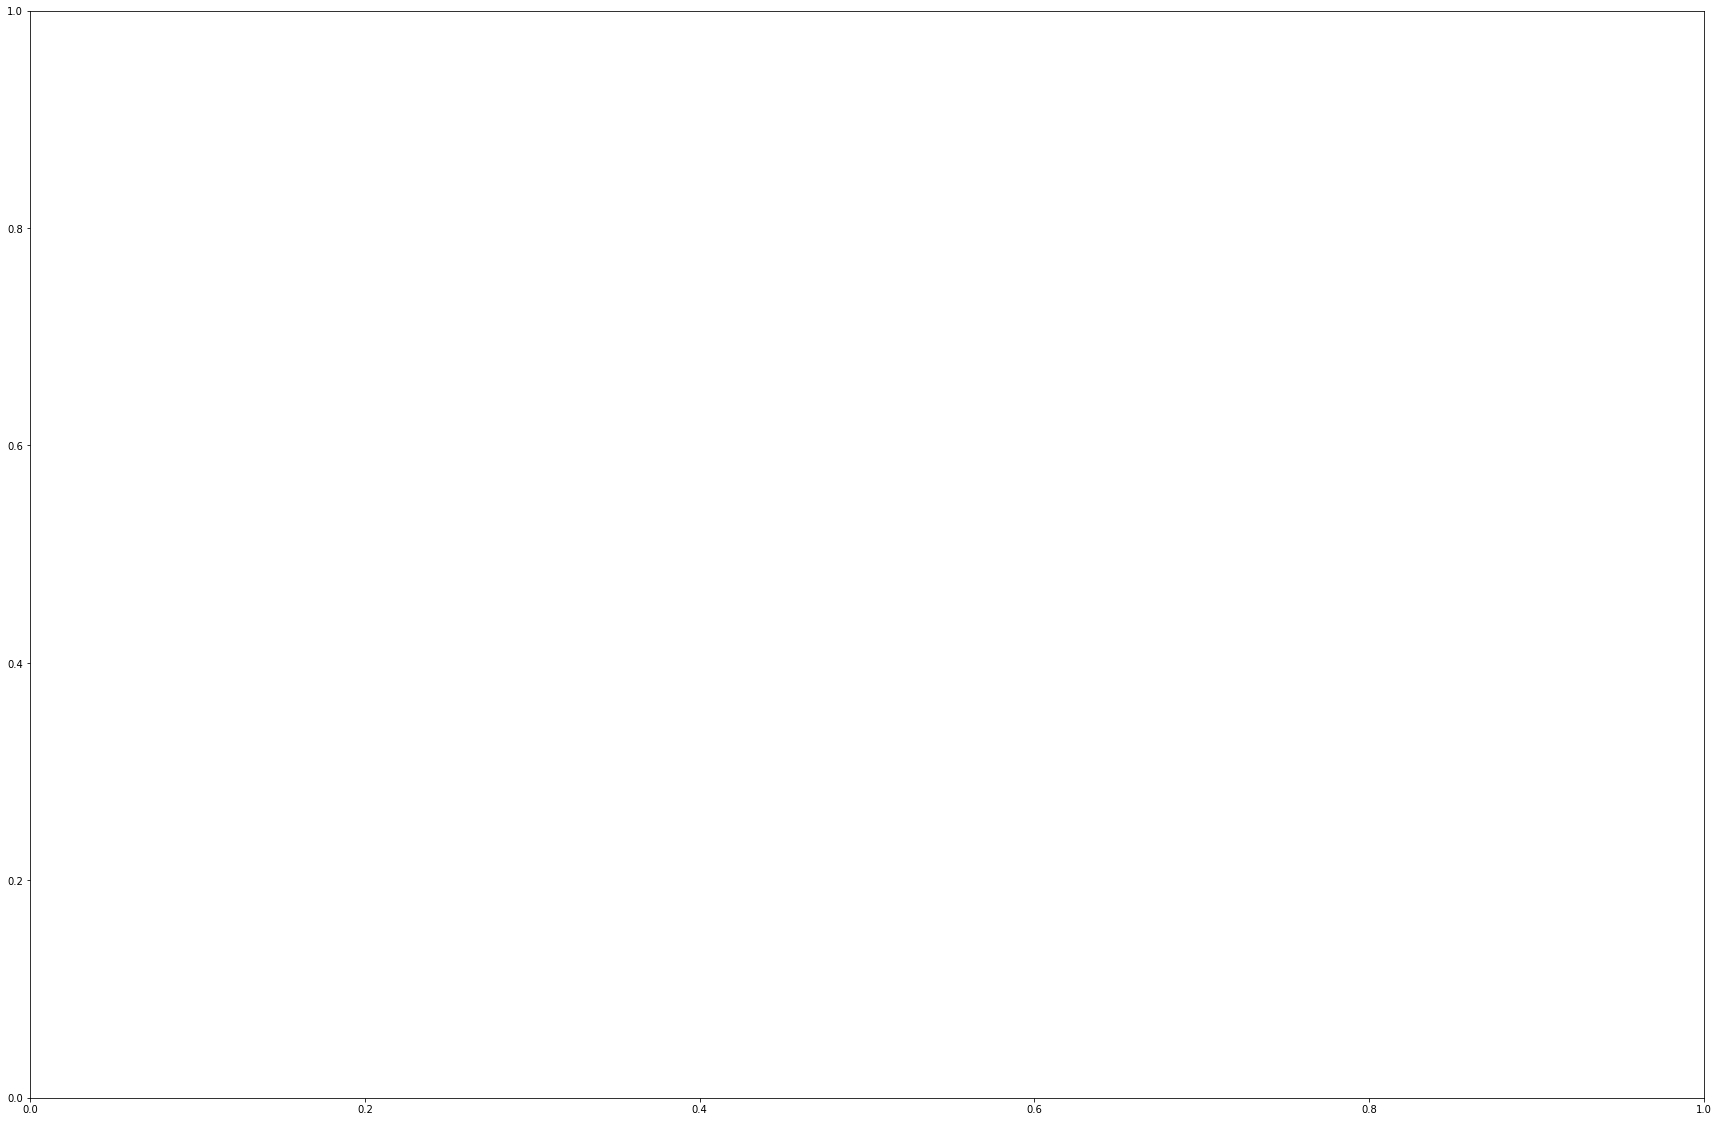

In [70]:
plot_bar_x()